#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [ ]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [ ]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    N = X.shape[0]
    linear_term = X.dot(w) + w0
    loss = np.log(1 + np.exp(-y * linear_term)).mean()
    l1_penalty = gamma * np.sum(np.abs(w))
    l2_penalty = beta * np.sum(np.square(w))

    return loss + l1_penalty + l2_penalty

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [ ]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    # Вычисление градиентов весов и смещения
    N = X.shape[0]
    linear_term = X.dot(w) + w0
    probs = 1 / (1 + np.exp(-y * linear_term))

    # Градиенты для весов
    grad_w = -np.dot(X.T, y * (1 - probs)) / N + gamma * np.sign(w) + 2 * beta * w

    # Градиент для смещения
    grad_w0 = -np.sum(y * (1 - probs)) / N

    return grad_w, grad_w0

In [ ]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = 0.0

    def fit(self, X: np.ndarray, y: np.ndarray):
        np.random.seed(self.random_state)
        self.w = np.random.randn(X.shape[1])
        self.w0 = 0.0

        for _ in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            # Условие остановки по изменению градиента
            if np.linalg.norm(grad_w) < self.tolerance and abs(grad_w0) < self.tolerance:
                break

        return self

    def predict(self, X: np.ndarray) -> List[int]:
        return (X.dot(self.w) + self.w0 >= 0).astype(int)

    def predict_proba(self, X: np.ndarray) -> List[float]:
        linear_term = X.dot(self.w) + self.w0
        proba = 1 / (1 + np.exp(-linear_term))
        return proba

In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, levels=[-1, 0, 1], colors=["#ffaaaa", "#aaffaa"])
    plt.scatter(X[y == -1, 0], X[y == -1, 1], color="red", edgecolor="k")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", edgecolor="k")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()

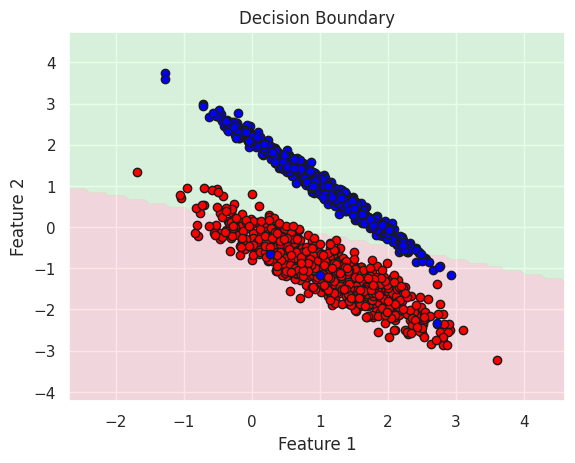

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_history, label='Loss')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss Function Over Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_loss_history(model)

AttributeError: 'Logit' object has no attribute 'loss_history'

<Figure size 1000x600 with 0 Axes>

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Параметры для экспериментов
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10]

# Хранение результатов
results = []

for kernel in kernels:
    for C in C_values:
        # Инициализация и обучение модели
        svc_model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        svc_model.fit(X_train, y_train)

        # Предсказания
        y_pred = svc_model.predict(X_test)
        y_prob = svc_model.predict_proba(X_test)[:, 1]  # Вероятности для AUC-ROC

        # Вычисление метрик
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)

        # Сохранение результата
        results.append({
            'kernel': kernel,
            'C': C,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'auc_roc': auc_roc,
            'f1_score': f1
        })

# Выводим результаты
for result in results:
    print(f"Kernel: {result['kernel']}, C: {result['C']}")
    print(f"  Accuracy: {result['accuracy']:.3f}")
    print(f"  Precision: {result['precision']:.3f}")
    print(f"  Recall: {result['recall']:.3f}")
    print(f"  AUC-ROC: {result['auc_roc']:.3f}")
    print(f"  F1 Score: {result['f1_score']:.3f}")
    print("-" * 30)


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        return [self._predict(x) for x in X]

    def _predict(self, x):
        distances = self._compute_distances(x)
        k_indices = np.argsort(distances)[:self.n_neighbors]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return Counter(k_nearest_labels).most_common(1)[0][0]

    def predict_proba(self, X):
        probabilities = []
        for x in X:
            distances = self._compute_distances(x)
            k_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            label_counts = Counter(k_nearest_labels)
            total_count = len(k_nearest_labels)
            probabilities.append([label_counts.get(i, 0) / total_count for i in range(np.max(self.y_train) + 1)])
        return np.array(probabilities)

## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.

In [ ]:
Задача 1.Тк у нас есть два признака, которые одинаковы для всех объектов, модель логистической регрессии не сможет различить положительный
и отрицательный классы, тк при обучении на стохастическом градиентном спуске (SGD) градиенты функции потерь будут одинаковыми для всех объектов (все признаки одинаковы),
и модель не сможет обновлять свои веса в направлении, необходимом для разделения классов. В результате обучение не приведёт к нахождению разделяющей гиперплоскости,
и итоговая модель будет выдавать случайные или средние предсказания, не зависимые от истинного класса.